<a href="https://colab.research.google.com/github/babalooski/BIOE486/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import statements and paths
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


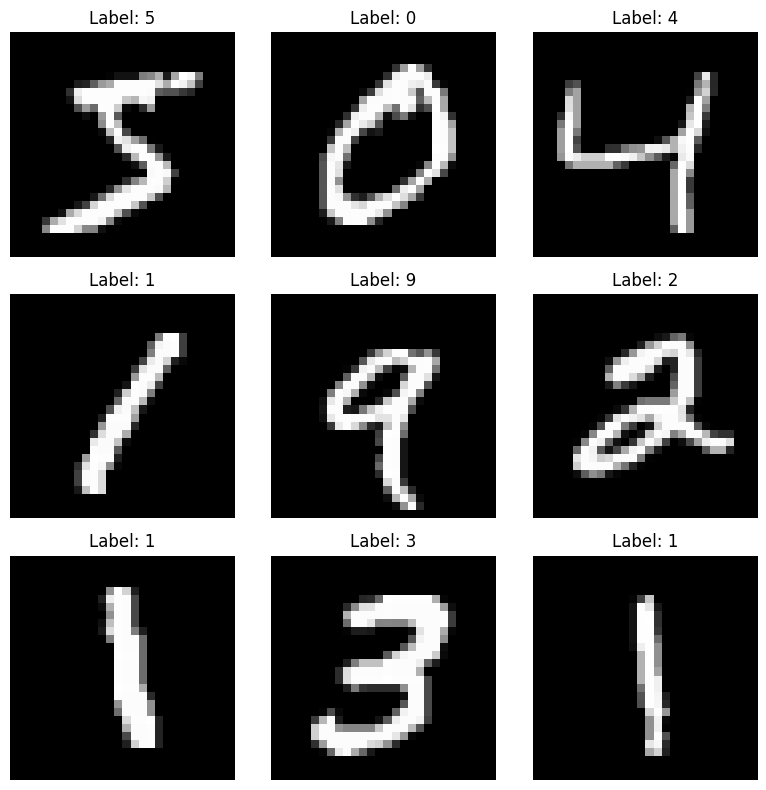

In [3]:
#Import the data
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_set = datasets.MNIST('./data', train=False, download=True)
train_X = train_set.data.numpy()
train_y = train_set.targets.numpy()
test_X = test_set.data.numpy()
test_y = test_set.targets.numpy()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_X[i], cmap='gray')
    ax.set_title(f"Label: {train_y[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# TASK 1: Visualize nine distinct images from the dataset.
# A plotting package has been imported for you - matplotlib.pyplot.
# You may use this package or another display method of your choosing, but it must be displayed in this notebook.
# A portion of your grade will be on the neatness and clarity of your plots.
#------------------------------------------------
#
# Provide your codes here
#
#------------------------------------------------

In [4]:
# TASK 2: Preprocess the data
# The image data (train_X, test_X) has been loaded as a set of numpy arrays of type uint8.
# Vectorize the data, convert the uint8s to floats, and scale the images to [0, 1].
# Additionally, append a unit with a value of 1 to each training and testing input.
# This value will represent a bias term when training the network.
# The final dimensions of your training and testing data should be (num_data, 785).
# Demonstrate that you have achieved these dimensions by DISPLAYING the DIMENSIONS of your preprocessed data
#------------------------------------------------
#
# Provide your codes here
#
#------------------------------------------------

train_X = train_X.reshape(train_X.shape[0], -1).astype(np.float32) / 255.0
test_X = test_X.reshape(test_X.shape[0], -1).astype(np.float32) / 255.0

train_X = np.hstack((train_X, np.ones((train_X.shape[0], 1))))
test_X = np.hstack((test_X, np.ones((test_X.shape[0], 1))))

print('Preprocessed X_train:', train_X.shape)
print('Preprocessed X_test: ', test_X.shape)

Preprocessed X_train: (60000, 785)
Preprocessed X_test:  (10000, 785)


In [46]:
# This class represents a multilayer perceptron with a single hidden layer.
# You will need to implement various functions for the next set of tasks.
# The functions will be detailed in the docstrings below.
# The tasks will have you implement them one at a time.
# Validation code will be provided for each step.
# Ensure that this passes before moving to the next task, as they build upon each other.
# You will need to employ and update the fields of the class to implement some of the methods.
# Do not edit anything outside of the designated functions.

class Numpy_Model():
    def __init__(self, n, debug=False):
        self.W1 = np.random.uniform(-0.05, 0.05, size=(n, 785))        # Weights implementing transform from input to hidden
        self.W2 = np.random.uniform(-0.05, 0.05, size=(10, (n + 1)))   # Weights implementing transform from hidden to output
        self.num_hidden_nodes = n                                      # number of hidden nodes

        self.delta_W1 = np.zeros(self.W1.shape)                        # previous gradient for W1 for mgd algorithm
        self.delta_W2 = np.zeros(self.W2.shape)                        # previous gradient for W2 for mgd algorithm
        self.alpha = 0.9                                               # momentum value for mgd algorithm
        self.learning_rate = 1e-1                                      # learning rate for mgd algorithm
        self.num_epochs = 10                                           # number of epochs to train for

        self.training_record = []                                      # Used to compute training accuracy
        self.test_record = []                                          # Used to compute test accuracy

        self.confusion_matrix = np.zeros((10, 10)).astype(int)         #Used to record the confucsion matrix

        self.debug = debug                                             # Toggles the display of convergence information

    def train(self, training_data, training_labels, test_data, test_labels):
        for epoch in range(0, self.num_epochs+1):
            print("Epoch " + str(epoch) + ":")
            trainingHits = 0
            testHits = 0
            for x in range(0, len(training_data)):
                input_data = training_data[x].reshape((training_data[x].shape[0], 1))
                hidden_activations, output_activations, predictions = self.forward(input_data)

                label_data = np.full((10,1),0)
                label_data[training_labels[x],0] = 1.0

                if epoch > 0:
                    gradient_W1, gradient_W2 = self.backward(input_data, hidden_activations, output_activations, label_data)
                    self.mgd(gradient_W1, gradient_W2)

                if(label_data[predictions] == 1.0):
                    trainingHits+=1

            training_Accuracy = (trainingHits / len(training_data)) * 100
            self.training_record.append(training_Accuracy)
            if self.debug:
                print("Training Accuracy: ", training_Accuracy)

            self.confusion_matrix = np.zeros((10, 10)).astype(int)

            for x in range(0, len(test_data)):
                input_data = test_data[x].reshape((test_data[x].shape[0], 1))

                hidden_activations, output_activations, predictions = self.forward(input_data)

                label_data = np.full((10,1),0)
                label_data[test_labels[x],0] = 1.0

                # If predicted value matches target, increment no. of hits
                if (label_data[predictions] == 1.0):
                    testHits += 1

                # Record prediction in confusion matrix
                self.confusion_matrix[test_labels[x], predictions] += 1

            # Compute accuracy on dataset as fraction of correct classification
            test_Accuracy = (testHits / len(test_data)) * 100
            self.test_record.append(test_Accuracy)
            if self.debug:
                print("Test Accuracy: ", test_Accuracy)
                print("")

    def forward(self, input_data):
        """
        Performs the forward pass.
        Uses class fields W1 and W2, representing the first and second weights, respectively
        Also uses the class function activation, which applies the activation function
        Remember to concatenate a 1 to the hidden layer activation to represent the bias term.

        Inputs:
        input_data: a single mnist image sample, flattened and with a bias term added (dims: [785, 1])

        Outputs:
        hidden_layer: the values after propogating the input data through the first layer, including the activation function
        output_layer: the values after propogating the input data through both layers, including activation functions
        predicted_output: a single output value indicating the predicted class
        """
        #------------------------------------------------
        #
        # Provide your codes here
        #
        #------------------------------------------------

        hidden_layer = self.activation(np.dot(self.W1, input_data))
        hidden_layer = np.vstack((hidden_layer, np.ones((1, hidden_layer.shape[1]))))
        output_layer = self.activation(np.dot(self.W2, hidden_layer))
        predicted_output = np.argmax(output_layer)
        return hidden_layer, output_layer, predicted_output

    def backward(self, input_data, hidden, output, target):
        """
        Implements the backprop algorithm.

        Inputs:
        hidden: the values after propogating the input data through the first layer, including the activation function
        output: the values after propogating the input data through both layers, including activation functions
        target: a [10,1] vector representing the label value, with the index representing the corresponding
            digit. As an example, when the true label for an image is 3, target[3] = 1.0 and target[0] = 0.0.

        Outputs:
        gradient_W1: gradient for W1, has dims (n, 785)
        gradient_W2: gradient for W2, has dims (10, n+1)
        """
        #------------------------------------------------
        #
        # Provide your codes here
        #
        #------------------------------------------------

        error_output = output - target
        gradient_W2 = (self.learning_rate * np.dot(hidden, error_output.T)).T
        error_hidden = np.dot(self.W2.T, error_output) * hidden * (1 - hidden)
        gradient_W1 = (self.learning_rate * np.dot(input_data,error_hidden[:-1].T)).T
        return gradient_W1, gradient_W2

    def mgd(self, gradient_W1, gradient_W2):
        """
        Implements a momentum gradient descent.
        Updates the fields W1, W2, delta_W1, and delta_W2.
        Additionally utilizes the alpha and learning rate parameters.

        Inputs:
        gradient_W1: gradient for W1, has dims (n, 785)
        gradient_W2: gradient for W2, has dims (10, n+1)
        """
        #------------------------------------------------
        #
        # Provide your codes here
        #
        #------------------------------------------------\
        self.delta_W1 = self.alpha * self.delta_W1 - self.learning_rate * gradient_W1
        self.delta_W2 = self.alpha * self.delta_W2 - self.learning_rate * gradient_W2
        self.W1 += self.delta_W1
        self.W2 += self.delta_W2

    def activation(self, x):
        return self._sigmoid(x)

    def _sigmoid(self, x):
        return (1 / (1 + np.exp(-x)))

    def plot_accuracy(self):
        plt.figure(self.num_hidden_nodes)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(self.training_record, color = "red", label = 'training set accuracy')
        plt.plot(self.test_record, color = "green", label = 'testing set accuracy')
        plt.ylim(0, 100)
        plt.xlim(0, 10)
        plt.title('No. of hidden neurons (n): ' + str(self.num_hidden_nodes))
        #lgd = plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2)
        lgd = plt.legend()
        plt.savefig('accuracy_E1_n_'+str(self.num_hidden_nodes)+'.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [47]:
# TASK 3: Implement the forward propagation of the network and evaluate your results using this cell
# This cell contains only validation code - do not change the contents of this cell.
np.random.seed(243)
model = Numpy_Model(20) # creates a model with 20 hidden nodes in the hidden layer
hidden_activations, output_activations, prediction = model.forward(train_X[5].reshape((train_X[5].shape[0], 1)))

#Provided for your debugging purposes. Each of the values below should be close to zero
validation_hidden = np.array([[0.30892327],[0.49095506],[0.54782831],[0.46813871],[0.47085435],[0.45180553],[0.47135914],[0.52423588],[0.43035027],[0.41902605],[0.49954541],[0.46873501],[0.64737602],[0.43641939],[0.59849931],[0.36807404],[0.63082009],[0.49723405],[0.47756751],[0.58343625],[1.        ]])
print("Hidden activation validation:", np.linalg.norm(hidden_activations - validation_hidden))
validation_output = np.array([[0.52218596],[0.46847276],[0.47275573],[0.49887059],[0.51090319],[0.47481649],[0.50629801],[0.48767566],[0.49648036],[0.50903225]])
print("Output activation validation:", np.linalg.norm(output_activations - validation_output))
validation_prediction = 0
print("Prediciton validation:", np.linalg.norm(prediction - validation_prediction))

Hidden activation validation: 1.277198629782725e-08
Output activation validation: 8.005841847838801e-09
Prediciton validation: 0.0


In [48]:
# TASK 4: Implement the backward propagation for training the network
# This cell contains only validation code - do not change the contents of this cell.
np.random.seed(243)
model = Numpy_Model(20)
input_data = train_X[5].reshape((train_X[5].shape[0], 1))
hidden_activations, output_activations, prediction = model.forward(input_data)
label_data = np.full((10,1),0.0)
label_data[0,0] = 1.0
gradient_W1, gradient_W2 = model.backward(input_data, hidden_activations, output_activations, label_data)

#np.save(open("W1_gradient_val.npy", 'wb'), gradient_W1)
#np.save(open("W2_gradient_val.npy", 'wb'), gradient_W2)
W1_gradient_val = np.load("W1_gradient_val.npy")
W2_gradient_val = np.load("W2_gradient_val.npy")

#Provided for your debugging purposes. Each of the values below should be close to zero
print("W1 gradient validation:", np.linalg.norm(gradient_W1 - W1_gradient_val))
print("W2 gradient validation:", np.linalg.norm(gradient_W2 - W2_gradient_val))

W1 gradient validation: 0.11131150461162186
W2 gradient validation: 0.8543967534142255


Epoch 0:
Training Accuracy:  9.863333333333333
Test Accuracy:  9.58

Epoch 1:
Training Accuracy:  90.17833333333334
Test Accuracy:  91.0

Epoch 2:
Training Accuracy:  92.88499999999999
Test Accuracy:  92.55

Epoch 3:
Training Accuracy:  93.46666666666667
Test Accuracy:  93.21000000000001

Epoch 4:
Training Accuracy:  93.77499999999999
Test Accuracy:  93.56

Epoch 5:
Training Accuracy:  94.26166666666667
Test Accuracy:  93.27

Epoch 6:
Training Accuracy:  94.44500000000001
Test Accuracy:  93.46

Epoch 7:
Training Accuracy:  94.76166666666667
Test Accuracy:  93.53

Epoch 8:
Training Accuracy:  94.89333333333333
Test Accuracy:  93.65

Epoch 9:
Training Accuracy:  94.935
Test Accuracy:  93.62

Epoch 10:
Training Accuracy:  95.02166666666668
Test Accuracy:  93.71000000000001

Confusion Matrix:
[[ 962    0    0    3    2    9    1    2    1    0]
 [   0 1121    2    3    0    2    3    0    3    1]
 [   8    3  941   27    8    4    3   10   28    0]
 [   1    5    5  960    1   13    2    9

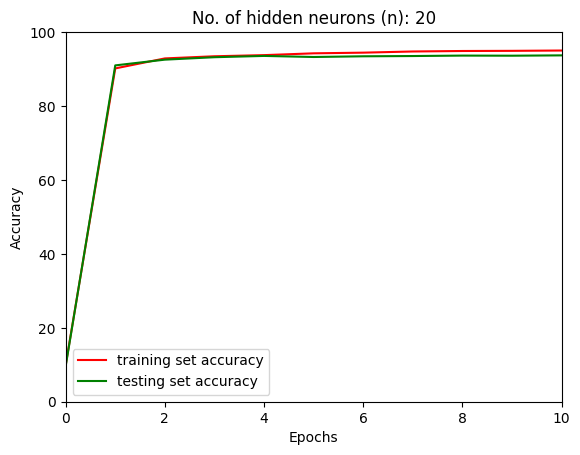

In [32]:
# TASK 5: Implement the mgd function of the network, which performs momentum gradient descent
# If performed successfully, the model should converge to above 90% accuracy for both training and testing data
# Note that epoch 0 does not contain any updates to the weights - it provides a baseline of model performance pre-training.
# This cell contains only validation code - do not change the contents of this cell.
model = Numpy_Model(20, debug=True)
model.train(train_X, train_y, test_X, test_y)
model.plot_accuracy()
print("Confusion Matrix:")
print(model.confusion_matrix)

In [ ]:
# TASK 6: Vary the number of hidden nodes
# ---GRADUATE CREDIT ONLY ---
# Choose 2 additional values for the hidden nodes.
# Train them and report on differences.
# Values that are significantly different from the current number of 20 will have the most interesting results.
# Use this space for your implementation and comments.
# You may insert additional blocks below to format your answer

In [ ]:
# Task 7: Implement one additional activation functions
# ---GRADUATE CREDIT ONLY ---
# Choose one other activation functions and implement them.
# Note that a new activation function necessitates a new backward function.
# Much of your previous implementation should still be usable.

class Custom_Model_1(Numpy_Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def activation(self, x):
        return self._custom_activation(x)

    def _custom_activation(self, x):
        """
        Implements your first custom activation function.

        Inputs:
        x: a numpy array of values

        Outputs:
        activation: the value after passing the input through the implemented activation function
        """
        #------------------------------------------------
        #
        # Provide your codes here
        #
        #------------------------------------------------
        return activation

    def backward(self, input_data, hidden, output, target):
        """
        Implements the backprop algorithm.

        Inputs:
        hidden: the values after propogating the input data through the first layer, including the activation function
        output: the values after propogating the input data through both layers, including activation functions
        target: a [10,1] vector representing the label value, with the index representing the corresponding
            digit. As an example, when the true label for an image is 3, target[3] = 1.0 and target[0] = 0.0.

        Outputs:
        gradient_W1: gradient for W1, has dims (n, 785)
        gradient_W2: gradient for W2, has dims (10, n+1)
        """
        #------------------------------------------------
        #
        # Provide your codes here
        #
        #------------------------------------------------

        return gradient_W1, gradient_W2

In [ ]:
# Use this space for your implementation and comments.
# You may insert additional blocks below to format your answer